### part0:imports

In [1]:
%matplotlib inline

from tqdm import tqdm
import os, sys, pathlib
from pprint import pprint
import gc, time
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)
warnings.simplefilter("ignore")

import PyPDF2 as ppdf
import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import scipy.linalg as linalg
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, r2_score
from scipy.stats import wilcoxon, mannwhitneyu, linregress
import math

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.lines as mlines
from matplotlib.ticker import MaxNLocator, FormatStrFormatter
from matplotlib.collections import LineCollection

import torch

import pyaldata as pyal

if "__file__" not in dir():
    try:
        NBPath = pathlib.Path.cwd()
        RepoPath = NBPath.parent
        os.chdir(RepoPath)

        from tools import utilityTools as utility
        from tools import dataTools as dt
        import params
        reload(params)
        defs = params.random_walk_defs

        set_rc =  params.set_rc_params
        set_rc()
        root = params.root

        os.chdir(RepoPath / 'random_walk')
        %run "_dataset-selection.ipynb"

    finally:
        os.chdir(NBPath)
    print('Done')

import warnings
warnings.filterwarnings("ignore")

Done


### Get data

In [2]:
def get_full_random_walk_data():
    full_list_MCx = []
    for animal, sessionList in GoodDataList['MCx'].items():
        full_list_MCx.append((animal,sessionList))
    full_list_MCx = [(animal,session) for animal,sessions in full_list_MCx for session in set(sessions)]
    # load the DFs
    allDFs_MCx = []
    allDFs_reaches_MCx = []
    for animal, session in full_list_MCx:
        path = root/'random_walk'/animal/session
        df_ = defs.prep_general(dt.load_pyal_data(path))
        allDFs_MCx.append(df_)

        #separate into reaches
        allDFs_reaches_MCx.append(defs.get_reaches_df(df_))
        
    return full_list_MCx, allDFs_MCx, allDFs_reaches_MCx

In [3]:
MCx_list, allDFs_MCx, allDFs_reaches_MCx = get_full_random_walk_data()

In [40]:
ex_file = 'Chewie_RT_CS_2016-10-21.mat'
i = [y for x,y in MCx_list].index(ex_file)

df = allDFs_MCx[i]
reaches_df = allDFs_reaches_MCx[i]

exec_df = reaches_df.copy()
for col in exec_df.columns:  #TODO: placeholder to prevent bug in pyaldata
        if 'unit_guide' in col:
            exec_df = exec_df.drop([col], axis = 1)
exec_df = pyal.add_movement_onset(exec_df)
exec_df = pyal.restrict_to_interval(exec_df, epoch_fun=defs.exec_epoch)
exec_df.reset_index();

print(MCx_list[i])


('Chewie', 'Chewie_RT_CS_2016-10-21.mat')


### Check rates

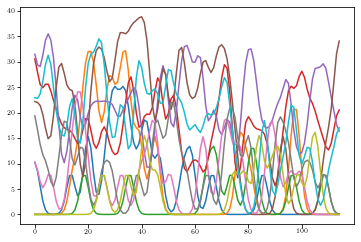

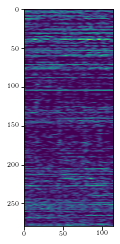

In [41]:
%matplotlib inline
rates = df.MCx_rates.values[0]
# print(reaches_df.columns)
plt.figure()
for i in range(10):
    plt.plot(rates[:,i])
    
fig, ax = plt.subplots()
ax.imshow(rates.T)


### Check positions of reaches

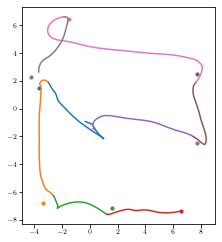

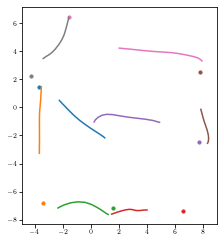

In [42]:
%matplotlib inline

#whole trial
ntrials = 8
plt.figure()
for pos,targets in zip(reaches_df.pos[:ntrials], reaches_df.target_center[:ntrials]):
    plt.plot(*pos[:].T)
    plt.scatter(*targets[:].T, s = 10)
plt.gca().set_aspect(1)

#movement epoch
plt.figure()
for pos,targets in zip(exec_df.pos[:ntrials], exec_df.target_center[:ntrials]):
    plt.plot(*pos[:].T)
    plt.scatter(*targets[:].T, s = 10)
plt.gca().set_aspect(1)

#### Subset trials

In [44]:
subset_radius = 2.5

#subset for whole trial
reaches_df = reaches_df[reaches_df.dist_start_center < subset_radius]
reaches_df = reaches_df.reset_index()

#subset for movement epoch
exec_df = exec_df[exec_df.dist_start_center < subset_radius]
exec_df = exec_df.reset_index()

print('Trials (subset, subset_movement):', len(reaches_df), len(exec_df))

Trials (subset, subset_movement): 262 233


#### Plot centered positions

(-10.0, 10.0)

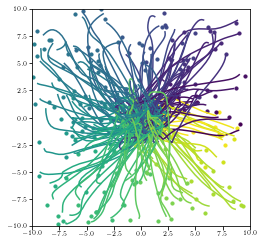

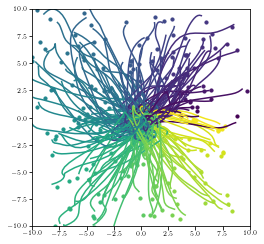

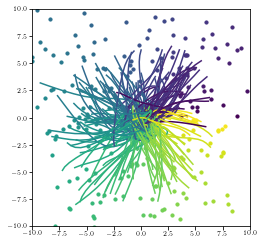

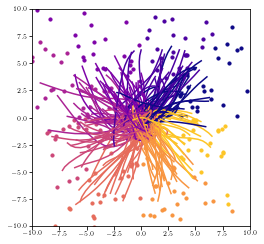

In [45]:
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(0, 360)

#subset reaches that start around the center
ntrials = 200
plt.figure()
for i in range(ntrials):
    pos = reaches_df.pos.values[i]
    targets = reaches_df.target_center.values[i]
    angle = reaches_df.target_angle.values[i]
    plt.plot(*pos[:].T, c=cmap(norm(angle)))
    plt.scatter(*targets[:].T, s = 10, c=cmap(norm(angle)))
plt.gca().set_aspect(1)
plt.xlim([-10,10])
plt.ylim([-10,10])

#subset reaches that start around the center, centered reaches
plt.figure()
for i in range(ntrials):
    pos = reaches_df.pos_centered.values[i]
    targets = reaches_df.target_centered.values[i]
    angle = reaches_df.target_angle.values[i]
    plt.plot(*pos[:].T, c=cmap(norm(angle)))
    plt.scatter(*targets[:].T, s = 10, c=cmap(norm(angle)))
plt.gca().set_aspect(1)
plt.xlim([-10,10])
plt.ylim([-10,10])

#subset reaches that start around the center, centered reaches, movement only
plt.figure()
for i in range(ntrials):
    pos = exec_df.pos_centered.values[i]
    targets = exec_df.target_centered.values[i]
    angle = exec_df.target_angle.values[i]
    plt.plot(*pos[:].T, c=cmap(norm(angle)))
    plt.scatter(*targets[:].T, s = 10, c=cmap(norm(angle)))
plt.gca().set_aspect(1)
plt.xlim([-10,10])
plt.ylim([-10,10])

#subset reaches that start around the center, centered reaches, movement only, grouped
colors = utility.get_colors(defs.n_target_groups)
plt.figure()
for i in range(ntrials):
    pos = exec_df.pos_centered.values[i]
    targets = exec_df.target_centered.values[i]
    target_group = exec_df.target_group.values[i]
    plt.plot(*pos[:].T, c=colors[target_group])
    plt.scatter(*targets[:].T, s = 10, c=colors[target_group])
plt.gca().set_aspect(1)
plt.xlim([-10,10])
plt.ylim([-10,10])